In [1210]:
#%pylab inline
from scipy.special import j0, j1
import numpy as np
import random
import copy as cp
import itertools as itrt
import matplotlib.pyplot as plt
#%config Completer.use_jedi = False
font_size = 16
# Update the rcParams dictionary to set the font size globally
plt.rcParams.update({'font.size': font_size})

In [1211]:
def gamma_to_beta(gamma):
    return sqrt(1-1/gamma**2)
def kinetic_to_betagamma(energy, rest_energy):
    gamma = energy/rest_energy+1
    beta = gamma_to_beta(gamma)
    return beta, gamma

In [1212]:
def negposone():
    return 1 if random.random() < 0.5 else -1

In [1213]:
def gaussian_curve(x, max_value, mean, std_dev):
    """
    Generates a smoothly increasing value along a Gaussian curve from zero to a maximum and then to zero again.

    Arguments:
    x -- The input value.
    max_value -- The maximum value of the curve.
    mean -- The mean (center) of the curve.
    std_dev -- The standard deviation of the curve.

    Returns:
    A smoothly increasing value along the Gaussian curve.
    """
    exponent = -(x - mean) ** 2 / (2 * std_dev ** 2)
    return max_value * np.exp(exponent)

In [1214]:
def conducting_flat(vector,wall_Z,apt_R):
    """ 
    taking losses at the circular aperture and generating a full image bunch reflecting off a flat wall
    
    includes cutoffs for particles striking wall or passing through the aperture
    """
    result = {}
    result['x'] = np.zeros_like(vector['x'])
    result['y'] = np.zeros_like(vector['y'])
    result['z'] = np.zeros_like(vector['z'])
    result['t'] = np.zeros_like(vector['t'])
    result['Px'] = np.zeros_like(vector['Px'])
    result['Py'] = np.zeros_like(vector['Py'])
    result['Pz'] = np.zeros_like(vector['Pz'])
    result['Pt'] = np.zeros_like(vector['Pt'])
    result['gamma'] = np.zeros_like(vector['gamma'])
    result['bx'] = np.zeros_like(vector['bx'])
    result['by'] = np.zeros_like(vector['by'])
    result['bz'] = np.zeros_like(vector['bz'])
    result['bdotx'] = np.zeros_like(vector['bdotx'])
    result['bdoty'] =np.zeros_like(vector['bdoty'])
    result['bdotz'] = np.zeros_like(vector['bdotz'])
    result['q'] = np.copy(vector['q']) #deep numpy copy
    
    for i in range(len(vector['x'])):
        r = np.sqrt(vector['x'][i]**2+vector['y'][i]**2)
#         #turning off images for particles passing the wall
        if vector['z'][i]>=wall_Z:
            result['q'] = 0
            #result['x'][i]=vector['x'][i]
            #result['y'][i]=vector['y'][i]
            #result['z'][i]=10
            #break
        #vector['z'][i]<wall_Z and r<=apt_R:
        else:
            result['q']=-vector['q']
            result['z'][i]=wall_Z + np.abs(wall_Z-vector['z'][i])
        #result['z'][i]=wall_Z + 2*(wall_Z-vector['z'][i])
        R_dist = np.abs(result['z'][i]-vector['z'][i])
        #print(R_dist)
        if R_dist/2 > apt_R:
            theta = np.arccos(-2*(apt_R**2)/(R_dist**2)+1)
            signchoicex = negposone()
            signchoicey = negposone()
            # if vector['x'][i]>0: 
            #     signchoicex= 1
            # else:
            #     signchoicex= -1
            # if vector['y'][i]>0:
            #     signchoicey= 1
            # else:
            #     signchoicey= -1
            if theta<np.pi/4:
                shift = 2*R_dist*np.tan(theta)
                result['x'][i]=vector['x'][i]+(apt_R + shift/np.sqrt(2))*signchoicex #moving image charge to nearest point on aperture wall
                result['y'][i]=vector['y'][i]+(apt_R + shift/np.sqrt(2))*signchoicey
                result['q']=result['q']*( 1-2*(apt_R**2)/(R_dist**2)*1/(1-np.cos(np.pi/2)) )  #adjusting image charge magnitude to avaiable solid angle fraction of reflected charge
            else:
                shift=0
                result['q']=0
                result['x'][i]=vector['x'][i]
                result['y'][i]=vector['y'][i]
        else:
            result['q']=0
            result['x'][i]=vector['x'][i]
            result['y'][i]=vector['y'][i]
            
        #result['x'][i]=vector['x'][i]
        #result['y'][i]=vector['y'][i]    
        result['Px'][i]=vector['Px'][i]
        result['Py'][i]=vector['Py'][i]
        result['Pz'][i]=-vector['Pz'][i]
        result['Pt'][i]=vector['Pt'][i] #right?
        result['gamma'][i]=vector['gamma'][i]
        result['bx'][i]=vector['bx'][i] 
        result['by'][i]=vector['by'][i]
        result['bz'][i]=-vector['bz'][i]
        result['bdotx'][i]=vector['bdotx'][i] 
        result['bdoty'][i]=vector['bdoty'][i] 
        result['bdotz'][i]=vector['bdotz'][i] 
        result['t'][i]=vector['t'][i]   #do NOT retard here, image charge is made to exist at the moment the original charge is created
 
    return(result)

In [1215]:
def switching_flat(vector,wall_Z,apt_R,cut_Z):
    """ 
    taking losses at the circular aperture and generating a full image bunch reflecting off a flat wall
    
    includes cutoffs for particles striking wall or passing through the aperture
    
    becomes an absorber at a designated time (i.e. the image charge effectively disappears)
    
    """
    result = {}
    result['x'] = np.zeros_like(vector['x'])
    result['y'] = np.zeros_like(vector['y'])
    result['z'] = np.zeros_like(vector['z'])
    result['t'] = np.zeros_like(vector['t'])
    result['Px'] = np.zeros_like(vector['Px'])
    result['Py'] = np.zeros_like(vector['Py'])
    result['Pz'] = np.zeros_like(vector['Pz'])
    result['Pt'] = np.zeros_like(vector['Pt'])
    result['gamma'] = np.zeros_like(vector['gamma'])
    result['bx'] = np.zeros_like(vector['bx'])
    result['by'] = np.zeros_like(vector['by'])
    result['bz'] = np.zeros_like(vector['bz'])
    result['bdotx'] = np.zeros_like(vector['bdotx'])
    result['bdoty'] =np.zeros_like(vector['bdoty'])
    result['bdotz'] = np.zeros_like(vector['bdotz'])
    result['q'] = np.copy(vector['q']) #numpy deep copy
    
    for i in range(len(vector['x'])):
        r = np.sqrt(vector['x'][i]**2+vector['y'][i]**2)
#         #turning off images for particles passing the wall
        if vector['z'][i]>=cut_Z: # or vector['t'][i] >= z_cutoffime: 
            result['q'] = 0
            #result['x'][i]=vector['x'][i]
            #result['y'][i]=vector['y'][i]
            #result['z'][i]=10
            #break
        #vector['z'][i]<wall_Z and r<=apt_R:
        else:
            result['q']=-np.copy(vector['q']) #numpy deep copy
            result['z'][i]=wall_Z + np.abs(wall_Z-vector['z'][i])
            result['x'][i]=vector['x'][i]
            result['y'][i]=vector['y'][i]
                
            
        #result['x'][i]=vector['x'][i]
        #result['y'][i]=vector['y'][i]    
        result['Px'][i]=vector['Px'][i]
        result['Py'][i]=vector['Py'][i]
        result['Pz'][i]=-vector['Pz'][i]
        result['Pt'][i]=vector['Pt'][i] #right?
        result['gamma'][i]=vector['gamma'][i]
        result['bx'][i]=vector['bx'][i] 
        result['by'][i]=vector['by'][i]
        result['bz'][i]=-vector['bz'][i]
        result['bdotx'][i]=vector['bdotx'][i] 
        result['bdoty'][i]=vector['bdoty'][i] 
        result['bdotz'][i]=vector['bdotz'][i] 
        result['t'][i]=vector['t'][i]   #do NOT retard here, image charge is made to exist at the moment the original charge is created
 
    return(result)

In [1216]:
def conducting_repeater(vector,vector_driver,wall_Z,apt_R):
    """ 
    generates a driving bunch synchronized to mimic a two transversly passing bunches
    (by monotonically increasing and decreasing q)
    
    """
    if vector_driver['q'] == 0 :
        result = {}
        result['x'] = np.zeros_like(vector_driver['x'])
        result['y'] = np.zeros_like(vector_driver['y'])
        result['z'] = np.zeros_like(vector_driver['z'])
        result['t'] = np.zeros_like(vector_driver['t'])
        result['Px'] = np.zeros_like(vector_driver['Px'])
        result['Py'] = np.zeros_like(vector_driver['Py'])
        result['Pz'] = np.zeros_like(vector_driver['Pz'])
        result['Pt'] = np.zeros_like(vector_driver['Pt'])
        result['gamma'] = np.zeros_like(vector_driver['gamma'])
        result['bx'] = np.zeros_like(vector_driver['bx'])
        result['by'] = np.zeros_like(vector_driver['by'])
        result['bz'] = np.zeros_like(vector_driver['bz'])
        result['bdotx'] = np.zeros_like(vector_driver['bdotx'])
        result['bdoty'] =np.zeros_like(vector_driver['bdoty'])
        result['bdotz'] = np.zeros_like(vector_driver['bdotz'])
        result['q'] = np.copy(vector_driver['q']) #deep numpy copy
    
    for i in range(len(vector['x'])):
        r = np.sqrt(vector['x'][i]**2+vector['y'][i]**2)
#         #turning off images for particles passing the wall
        if vector['z'][i]>=wall_Z:
            result['q'] = 0
            #result['x'][i]=vector['x'][i]
            #result['y'][i]=vector['y'][i]
            #result['z'][i]=10
            #break
        #vector['z'][i]<wall_Z and r<=apt_R:
        else:
            result['q']=-vector['q']
            result['z'][i]=wall_Z + np.abs(wall_Z-vector['z'][i])
        #result['z'][i]=wall_Z + 2*(wall_Z-vector['z'][i])
        R_dist = np.abs(result['z'][i]-vector['z'][i])
        #print(R_dist)
        if R_dist/2 > apt_R:
            theta = np.arccos(-2*(apt_R**2)/(R_dist**2)+1)
            signchoicex = negposone()
            signchoicey = negposone()
            # if vector['x'][i]>0: 
            #     signchoicex= 1
            # else:
            #     signchoicex= -1
            # if vector['y'][i]>0:
            #     signchoicey= 1
            # else:
            #     signchoicey= -1
            if theta<np.pi/4:
                shift = 2*R_dist*np.tan(theta)
                result['x'][i]=vector['x'][i]+(apt_R + shift/np.sqrt(2))*signchoicex #moving image charge to nearest point on aperture wall
                result['y'][i]=vector['y'][i]+(apt_R + shift/np.sqrt(2))*signchoicey
                result['q']=result['q']*( 1-2*(apt_R**2)/(R_dist**2)*1/(1-np.cos(np.pi/2)) )  #adjusting image charge magnitude to avaiable solid angle fraction of reflected charge
            else:
                shift=0
                result['q']=0
                result['x'][i]=vector['x'][i]
                result['y'][i]=vector['y'][i]
        else:
            result['q']=0
            result['x'][i]=vector['x'][i]
            result['y'][i]=vector['y'][i]
            
        #result['x'][i]=vector['x'][i]
        #result['y'][i]=vector['y'][i]    
        result['Px'][i]=vector['Px'][i]
        result['Py'][i]=vector['Py'][i]
        result['Pz'][i]=-vector['Pz'][i]
        result['Pt'][i]=vector['Pt'][i] #right?
        result['gamma'][i]=vector['gamma'][i]
        result['bx'][i]=vector['bx'][i] 
        result['by'][i]=vector['by'][i]
        result['bz'][i]=-vector['bz'][i]
        result['bdotx'][i]=vector['bdotx'][i] 
        result['bdoty'][i]=vector['bdoty'][i] 
        result['bdotz'][i]=vector['bdotz'][i] 
        result['t'][i]=vector['t'][i]   #do NOT retard here, image charge is made to exist at the moment the original charge is created
 
    return(result)

In [1217]:
def dist_euclid(vector,vector_ext,index):
    """
    simple Euclidean distance generator 
    
    """
    result = {}
    result['R'] = np.zeros_like(vector['x'])    
    result['nx'] = np.zeros_like(vector['x'])
    result['ny'] = np.zeros_like(vector['x'])    
    result['nz'] = np.zeros_like(vector['x'])    
    for j in range(len(vector_ext['x'])):
        result['R'][j] = np.sqrt( (vector['x'][index]-vector_ext['x'][j])**2+
                          (vector['y'][index]-vector_ext['y'][j])**2+
                          (vector['z'][index]-vector_ext['z'][j])**2 )
        result['nx'][j] = (vector['x'][index]-vector_ext['x'][j])/result['R'][j]
        result['ny'][j] = (vector['y'][index]-vector_ext['y'][j])/result['R'][j]
        result['nz'][j] = (vector['z'][index]-vector_ext['z'][j])/result['R'][j]
    return(result)

In [1218]:
def dist_euclid_ret(trajectory,trajectory_ext,index_traj,index_part,indices_ret):
    """
    simple Euclidean distance generator 
    
    """
    result = {}
    result['R'] = np.zeros_like(trajectory[index_traj]['x'])    
    result['nx'] = np.zeros_like(trajectory[index_traj]['x'])
    result['ny'] = np.zeros_like(trajectory[index_traj]['x'])    
    result['nz'] = np.zeros_like(trajectory[index_traj]['x'])    
    for j in range(len(trajectory[index_traj]['x'])):
        result['R'][j] = np.sqrt( (trajectory[index_traj]['x'][index_part]-trajectory_ext[indices_ret[j]]['x'][j])**2+
                          (trajectory[index_traj]['y'][index_part]-trajectory_ext[indices_ret[j]]['y'][j])**2+
                          (trajectory[index_traj]['z'][index_part]-trajectory_ext[indices_ret[j]]['z'][j])**2 )
        result['nx'][j] = (trajectory[index_traj]['x'][index_part]-trajectory_ext[indices_ret[j]]['x'][j])/result['R'][j]
        result['ny'][j] = (trajectory[index_traj]['y'][index_part]-trajectory_ext[indices_ret[j]]['y'][j])/result['R'][j]
        result['nz'][j] = (trajectory[index_traj]['z'][index_part]-trajectory_ext[indices_ret[j]]['z'][j])/result['R'][j]
    return(result)

In [1219]:
def eqsofmotion_static(h, vector,vector_ext,apt_R): # nhat includes R and fnhat components, need to generate this per particle pair
    result = {}
    result['x'] = np.zeros_like(vector['x'])
    result['y'] = np.zeros_like(vector['y'])
    result['z'] = np.zeros_like(vector['z'])
    result['t'] = np.zeros_like(vector['t'])
    result['Px'] = np.zeros_like(vector['Px'])
    result['Py'] = np.zeros_like(vector['Py'])
    result['Pz'] = np.zeros_like(vector['Pz'])
    result['Pt'] = np.zeros_like(vector['Pt'])
    result['gamma'] = np.zeros_like(vector['gamma'])
    result['bx'] = np.zeros_like(vector['bx'])
    result['by'] = np.zeros_like(vector['by'])
    result['bz'] = np.zeros_like(vector['bz'])
    result['bdotx'] = np.zeros_like(vector['bdotx'])
    result['bdoty'] =np.zeros_like(vector['bdoty'])
    result['bdotz'] = np.zeros_like(vector['bdotz'])
    result['q'] = vector['q']
    result['char_time'] = vector['char_time']
    result['m'] = vector['m']
    for i in range(len(vector['x'])):   #iterating over all real particles OR all reflection points (these must be done in separate steps)            
        nhat = dist_euclid(vector,vector_ext,i)
        for j in range(len(vector_ext['x'])): #summing all external contributions (reflected particles and/or local particles)
            #if nhat['R'][j] < 1.5*apt_R:
            #if vector['z'][j] > 0:
            #    vector_ext['q']=0
            
            beta_vec = (vector['bx'][i],vector['by'][i],vector['bz'][i])
            beta_ext = (vector_ext['bx'][j],vector_ext['by'][j],vector_ext['bz'][j])
            k_factor = (1-np.dot(beta_ext,(nhat['nx'][j],nhat['ny'][j],nhat['nz'][j])))
            bdot_ext = (vector_ext['bdotx'][j],vector_ext['bdoty'][j],vector_ext['bdotz'][j])
            bdot_scalar_mixed = np.dot(beta_vec,bdot_ext)
            bdot_scalar_ext = np.dot(beta_ext,bdot_ext)
            betas_scalar =  np.dot(beta_ext,beta_vec)
            #V_ext^beta * V_beta
            v_betas_scalar = vector_ext['gamma'][j]*vector['gamma'][i]*c**2*(1-betas_scalar)                
            #Vdot_ext^beta * V_beta
            v_beta_dot_mixed_scalar = vector_ext['gamma'][j]**4*vector['gamma'][i]*c**2*bdot_scalar_ext\
                        -vector['gamma'][i]*c*np.dot(beta_vec,\
                        np.multiply(bdot_ext,c*vector_ext['gamma'][j]**2)\
                        +np.multiply(beta_ext,bdot_scalar_ext)*c*vector_ext['gamma'][j]**4)

            result['Px'][i] = vector['Px'][i] +  h*vector['q']*vector_ext['q']\
                        *1/(k_factor**3*c**3*nhat['R'][j]**2*vector_ext['gamma'][j]**3)\
                        *(-v_betas_scalar*k_factor*c*vector_ext['gamma'][j]**2\
                           +v_beta_dot_mixed_scalar*k_factor*vector_ext['gamma'][j]*nhat['nx'][j]*nhat['R'][j]\
                           +vector_ext['gamma'][j]**2*nhat['nx'][j]**2*nhat['R'][j]\
                           *v_betas_scalar*(vector_ext['bdotx'][j]\
                           +vector_ext['bdotx'][j]*bdot_scalar_ext*vector_ext['gamma'][j]**2)\
                           +v_betas_scalar*c*nhat['nx'][j]
                         )


            result['Py'][i] = vector['Py'][i] +  h*vector['q']*vector_ext['q']\
                        *1/(k_factor**3*c**3*nhat['R'][j]**2*vector_ext['gamma'][j]**3)\
                        *(-v_betas_scalar*k_factor*c*vector_ext['gamma'][j]**2\
                           +v_beta_dot_mixed_scalar*k_factor*vector_ext['gamma'][j]*nhat['ny'][j]*nhat['R'][j]\
                           +vector_ext['gamma'][j]**2*nhat['ny'][j]**2*nhat['R'][j]\
                           *v_betas_scalar*(vector_ext['bdoty'][j]\
                           +vector_ext['bdoty'][j]*bdot_scalar_ext*vector_ext['gamma'][j]**2)\
                           +v_betas_scalar*c*nhat['ny'][j]
                         )

            result['Pz'][i] = vector['Pz'][i] +  h*vector['q']*vector_ext['q']\
                        *1/(k_factor*c**3*nhat['R'][j]**2*vector_ext['gamma'][j]**3)\
                        *(-v_betas_scalar*k_factor*c*vector_ext['gamma'][j]**2\
                           +v_beta_dot_mixed_scalar*k_factor*vector_ext['gamma'][j]*nhat['nz'][j]*nhat['R'][j]\
                           +vector_ext['gamma'][j]**2*nhat['nz'][j]**2*nhat['R'][j]\
                           *v_betas_scalar*(vector_ext['bdotz'][j]\
                           +vector_ext['bdotz'][j]*bdot_scalar_ext*vector_ext['gamma'][j]**2)\
                           +v_betas_scalar*c*nhat['nz'][j]
                        )


            result['Pt'][i] = vector['Pt'][i] + h*vector['q']*vector_ext['q']\
                        *1/(k_factor**3*c**2*nhat['R'][j]**2*vector_ext['gamma'][j]**3)\
                        *(v_beta_dot_mixed_scalar*k_factor*vector_ext['gamma'][j]*nhat['R'][j]\
                          -v_betas_scalar*k_factor*c*vector_ext['gamma'][j]**2\
                          -bdot_scalar_ext*v_betas_scalar*vector_ext['gamma'][j]**4*nhat['R'][j]\
                          +v_betas_scalar*c
                        )
            
            
            result['gamma'][i] = 1/(vector['m']*c)*(result['Pt'][i]-vector['q']/c*vector_ext['q']\
                        /(nhat['R'][j]*(1-np.dot((vector_ext['bx'][j],vector_ext['by'][j],vector_ext['bz'][j]),(nhat['nx'][j],nhat['ny'][j],nhat['nz'][j])))))
            
            result['t'][i] = vector['t'][i] + h * result['gamma'][i]  #note 't' is lab time and h is in proper time, so: dt/dtau=gamma 
            
            result['x'][i] = vector['x'][i] + h/vector['m']*(result['Px'][i]-vector['q']/c*vector_ext['q']*vector_ext['bx'][j]\
                        /(nhat['R'][j]*(1-np.dot((vector_ext['bx'][j],vector_ext['by'][j],vector_ext['bz'][j]),(nhat['nx'][j],nhat['ny'][j],nhat['nz'][j])))))
                        
            result['y'][i] = vector['y'][i] + h/vector['m']*(result['Py'][i]-vector['q']/c*vector_ext['q']*vector_ext['by'][j]\
                        /(nhat['R'][j]*(1-np.dot((vector_ext['bx'][j],vector_ext['by'][j],vector_ext['bz'][j]),(nhat['nx'][j],nhat['ny'][j],nhat['nz'][j])))))
            
            result['z'][i] = vector['z'][i] + h/vector['m']*(result['Pz'][i]-vector['q']/c*vector_ext['q']*vector_ext['bz'][j]\
                        /(nhat['R'][j]*(1-np.dot((vector_ext['bx'][j],vector_ext['by'][j],vector_ext['bz'][j]),(nhat['nx'][j],nhat['ny'][j],nhat['nz'][j])))))
            
            result['bx'][i] = (-vector['x'][i]+result['x'][i]) / (c*h*result['gamma'][i])
            result['by'][i] = (-vector['y'][i]+result['y'][i]) / (c*h*result['gamma'][i])
            result['bz'][i] = (-vector['z'][i]+result['z'][i]) / (c*h*result['gamma'][i])

            #'real' gamma 
            btots = np.sqrt(np.square(vector['bx'][i])+np.square(vector['by'][i])+np.square(vector['bz'][i]))
            result['gamma'][i] = np.sqrt(np.divide(1,1-np.square(btots)))
            
            if result['bz'][i] > 1:
                print(result['bz'][i])
                raise Exception("Beam-axis velocity exceeded c") 
            
            result['bdotx'][i] = (-vector['bx'][i]+result['bx'][i])/(c*h*result['gamma'][i])
            result['bdoty'][i] = (-vector['by'][i]+result['by'][i])/(c*h*result['gamma'][i])
            result['bdotz'][i] = (-vector['bz'][i]+result['bx'][i])/(c*h*result['gamma'][i])
            
            #NOTE---- Momentum values below are updated 'result', implicit technically, but only needs explicit solver for extreme cases
            
            
    return result

In [1220]:
def chrono_jn(trajectory,trajectory_ext,index_traj,index_part):
    nhat = dist_euclid(trajectory[index_traj],trajectory_ext[index_traj],index_part)
    index_traj_new = np.empty(len(trajectory_ext[index_traj]['x']),dtype=int)
    for l in range(len(trajectory_ext[index_traj]['x'])):
        b_nhat = trajectory_ext[index_traj]['bx'][l]*nhat['nx'][l]\
        +trajectory_ext[index_traj]['by'][l]*nhat['ny'][l]\
        +trajectory_ext[index_traj]['bz'][l]*nhat['nz'][l] #for accurate chrono-matching
        #b_nhat = trajectory[index_traj]['bz'][index_part]*nhat['nz'][l] #for speedup
        delta_t = nhat['R'][l]*(1+b_nhat)/c
        t_ext_new = trajectory_ext[index_traj]['t'][l]-delta_t
        if t_ext_new<0:
            index_traj_new[l] = index_traj
        else:
            for k in range(index_traj,-1,-1):
                if trajectory_ext[index_traj-k]['t'][l] > t_ext_new:
                    index_traj_new[l]=(index_traj-k)
                    break
    return(index_traj_new)    

In [1221]:
def eqsofmotion_retarded(h, trajectory,trajectory_ext,i_traj,apt_R): # nhat includes R and fnhat components, need to generate this per particle pair
    result = {}
    result['x'] = np.zeros_like(trajectory[i_traj]['x'])
    result['y'] = np.zeros_like(trajectory[i_traj]['y'])
    result['z'] = np.zeros_like(trajectory[i_traj]['z'])
    result['t'] = np.zeros_like(trajectory[i_traj]['t'])
    result['Px'] = np.zeros_like(trajectory[i_traj]['Px'])
    result['Py'] = np.zeros_like(trajectory[i_traj]['Py'])
    result['Pz'] = np.zeros_like(trajectory[i_traj]['Pz'])
    result['Pt'] = np.zeros_like(trajectory[i_traj]['Pt'])
    result['gamma'] = np.zeros_like(trajectory[i_traj]['gamma'])
    result['bx'] = np.zeros_like(trajectory[i_traj]['bx'])
    result['by'] = np.zeros_like(trajectory[i_traj]['by'])
    result['bz'] = np.zeros_like(trajectory[i_traj]['bz'])
    result['bdotx'] = np.zeros_like(trajectory[i_traj]['bdotx'])
    result['bdoty'] =np.zeros_like(trajectory[i_traj]['bdoty'])
    result['bdotz'] = np.zeros_like(trajectory[i_traj]['bdotz'])
    result['q'] = trajectory[i_traj]['q']
    result['char_time'] = trajectory[i_traj]['char_time']
    result['m'] = trajectory[i_traj]['m']
    result['dummy'] =  np.zeros_like(trajectory[i_traj]['bdotz'])
    for l in range(len(trajectory[i_traj]['x'])):   #iterating over all real particles OR all reflection points (these must be done in separate steps)            
            i_new = chrono_jn(trajectory,trajectory_ext,i_traj,l)  #notes: i_new is a list corresponding to the j index.... also, an intermediate nhat is being calculated here
            nhat = dist_euclid_ret(trajectory,trajectory_ext,i_traj,l,i_new)
            #print(l)
            #print(i)
            #print(i_new)
            for j in range(len(trajectory_ext[0]['x'])): #summing all external contributions (reflected particles and/or local particles)
                #if nhat['R'][j] < 1.5*apt_R:
                #if trajectory[i_traj]['z'][j] > 0:
                #    trajectory_ext[i_new[j]]['q']=0
                result['x'][l] = trajectory[i_traj]['x'][l]
                result['y'][l] = trajectory[i_traj]['y'][l]
                result['z'][l] = trajectory[i_traj]['z'][l]
                result['t'][l] = trajectory[i_traj]['t'][l]
                
                beta_vec = (trajectory[i_traj]['bx'][l],trajectory[i_traj]['by'][l],trajectory[i_traj]['bz'][l])
                beta_ext = (trajectory_ext[i_new[j]]['bx'][j],trajectory_ext[i_new[j]]['by'][j],trajectory_ext[i_new[j]]['bz'][j])
                k_factor = (1-np.dot(beta_ext,(nhat['nx'][j],nhat['ny'][j],nhat['nz'][j])))
                bdot_ext = (trajectory_ext[i_new[j]]['bdotx'][j],trajectory_ext[i_new[j]]['bdoty'][j],trajectory_ext[i_new[j]]['bdotz'][j])
                bdot_scalar_mixed = np.dot(beta_vec,bdot_ext)
                bdot_scalar_ext = np.dot(beta_ext,bdot_ext)
                betas_scalar =  np.dot(beta_ext,beta_vec)
                #V_ext^beta * V_beta
                v_betas_scalar = trajectory_ext[i_new[j]]['gamma'][j]*trajectory[i_traj]['gamma'][l]*c**2*(1-betas_scalar)                
                #Vdot_ext^beta * V_beta
                v_beta_dot_mixed_scalar = trajectory_ext[i_new[j]]['gamma'][j]**4*trajectory[i_traj]['gamma'][l]*c**2*bdot_scalar_ext\
                            -trajectory[i_traj]['gamma'][l]*c*np.dot(beta_vec,\
                            np.multiply(bdot_ext,c*trajectory_ext[i_new[j]]['gamma'][j]**2)\
                            +np.multiply(beta_ext,bdot_scalar_ext)*c*trajectory_ext[i_new[j]]['gamma'][j]**4)
                
                result['Px'][l] = trajectory[i_traj]['Px'][l] +  h*trajectory[i_traj]['q']*trajectory_ext[i_new[j]]['q']\
                            *1/(k_factor**3*c**3*nhat['R'][j]**2*trajectory_ext[i_new[j]]['gamma'][j]**3)\
                            *(-v_betas_scalar*k_factor*c*trajectory_ext[i_new[j]]['gamma'][j]**2\
                               +v_beta_dot_mixed_scalar*k_factor*trajectory_ext[i_new[j]]['gamma'][j]*nhat['nx'][j]*nhat['R'][j]\
                               +trajectory_ext[i_new[j]]['gamma'][j]**2*nhat['nx'][j]**2*nhat['R'][j]\
                               *v_betas_scalar*(trajectory_ext[i_new[j]]['bdotx'][j]\
                               +trajectory_ext[i_new[j]]['bdotx'][j]*bdot_scalar_ext*trajectory_ext[i_new[j]]['gamma'][j]**2)\
                               +v_betas_scalar*c*nhat['nx'][j]
                             )

                                
                result['Py'][l] = trajectory[i_traj]['Py'][l] +  h*trajectory[i_traj]['q']*trajectory_ext[i_new[j]]['q']\
                            *1/(k_factor**3*c**3*nhat['R'][j]**2*trajectory_ext[i_new[j]]['gamma'][j]**3)\
                            *(-v_betas_scalar*k_factor*c*trajectory_ext[i_new[j]]['gamma'][j]**2\
                               +v_beta_dot_mixed_scalar*k_factor*trajectory_ext[i_new[j]]['gamma'][j]*nhat['ny'][j]*nhat['R'][j]\
                               +trajectory_ext[i_new[j]]['gamma'][j]**2*nhat['ny'][j]**2*nhat['R'][j]\
                               *v_betas_scalar*(trajectory_ext[i_new[j]]['bdoty'][j]\
                               +trajectory_ext[i_new[j]]['bdoty'][j]*bdot_scalar_ext*trajectory_ext[i_new[j]]['gamma'][j]**2)\
                               +v_betas_scalar*c*nhat['ny'][j]
                             )
                
                result['Pz'][l] = trajectory[i_traj]['Pz'][l] +  h*trajectory[i_traj]['q']*trajectory_ext[i_new[j]]['q']\
                            *1/(k_factor*c**3*nhat['R'][j]**2*trajectory_ext[i_new[j]]['gamma'][j]**3)\
                            *(-v_betas_scalar*k_factor*c*trajectory_ext[i_new[j]]['gamma'][j]**2\
                               +v_beta_dot_mixed_scalar*k_factor*trajectory_ext[i_new[j]]['gamma'][j]*nhat['nz'][j]*nhat['R'][j]\
                               +trajectory_ext[i_new[j]]['gamma'][j]**2*nhat['nz'][j]**2*nhat['R'][j]\
                               *v_betas_scalar*(trajectory_ext[i_new[j]]['bdotz'][j]\
                               +trajectory_ext[i_new[j]]['bdotz'][j]*bdot_scalar_ext*trajectory_ext[i_new[j]]['gamma'][j]**2)\
                               +v_betas_scalar*c*nhat['nz'][j]
                            )
                
                
                result['Pt'][l] = trajectory[i_traj]['Pt'][l] + h*trajectory[i_traj]['q']*trajectory_ext[i_new[j]]['q']\
                            *1/(k_factor**3*c**2*nhat['R'][j]**2*trajectory_ext[i_new[j]]['gamma'][j]**3)\
                            *(v_beta_dot_mixed_scalar*k_factor*trajectory_ext[i_new[j]]['gamma'][j]*nhat['R'][j]\
                              -v_betas_scalar*k_factor*c*trajectory_ext[i_new[j]]['gamma'][j]**2\
                              -bdot_scalar_ext*v_betas_scalar*trajectory_ext[i_new[j]]['gamma'][j]**4*nhat['R'][j]\
                              +v_betas_scalar*c
                            )
                
                #initial guess gamma, avoids blowups (honestly it's a huge mystery why we need this and the gamma below, but blowups or conservation violation happen without
                result['gamma'][l] = 1/(trajectory[i_traj]['m']*c)*(result['Pt'][l]-trajectory[i_traj]['q']/c*trajectory_ext[i_new[j]]['q']\
                             *1/(nhat['R'][j]*k_factor))
                
                result['t'][l] = trajectory[i_traj]['t'][l] + h * result['gamma'][l]  #note 't' is lab time and h is in proper time, so: dt/dtau=gamma 
                
                result['x'][l] = trajectory[i_traj]['x'][l] + h/trajectory[i_traj]['m']*(result['Px'][l]-trajectory[i_traj]['q']/c*trajectory_ext[i_new[j]]['q']*trajectory_ext[i_new[j]]['bx'][j]\
                            /(nhat['R'][j]*k_factor))
                    
                result['y'][l] = trajectory[i_traj]['y'][l] + h/trajectory[i_traj]['m']*(result['Py'][l]-trajectory[i_traj]['q']/c*trajectory_ext[i_new[j]]['q']*trajectory_ext[i_new[j]]['by'][j]\
                            /(nhat['R'][j]*k_factor))
                
                result['z'][l] = trajectory[i_traj]['z'][l] + h/trajectory[i_traj]['m']*(result['Pz'][l]-trajectory[i_traj]['q']/c*trajectory_ext[i_new[j]]['q']*trajectory_ext[i_new[j]]['bz'][j]\
                            /(nhat['R'][j]*k_factor))
                
                
                result['bx'][l] = (-trajectory[i_traj]['x'][l]+result['x'][l])/ ( c*h  * result['gamma'][l])
                result['by'][l] = (-trajectory[i_traj]['y'][l]+result['y'][l])/ ( c*h  * result['gamma'][l])
                result['bz'][l] = (-trajectory[i_traj]['z'][l]+result['z'][l])/ ( c*h  * result['gamma'][l])
                
                #'real' gamma 
                btots = np.sqrt(np.square(trajectory[i_traj]['bx'][l])+np.square(trajectory[i_traj]['by'][l])+np.square(trajectory[i_traj]['bz'][l]))
                result['gamma'][l] = np.sqrt(np.divide(1,1-np.square(btots)))
                
                
                if result['bz'][l] > 1:
                    print(result['bz'][l])
                    raise Exception("Beam-axis velocity exceeded c")
                
                
                #result['bdotx'][l] = (result['bx'][l]-trajectory[i_traj]['bx'][l])/( c*h  * result['gamma'][l])
                #result['bdoty'][l] =(result['by'][l]-trajectory[i_traj]['by'][l])/( c*h  * result['gamma'][l])
                #result['bdotz'][l] = (result['bz'][l]-trajectory[i_traj]['bz'][l])/( c*h  * result['gamma'][l])
                
                result['bdotx'][l] = (-trajectory[i_traj]['bx'][l]+result['bx'][l])/( c*h  * result['gamma'][l])
                result['bdoty'][l] = (-trajectory[i_traj]['by'][l]+result['by'][l])/( c*h  * result['gamma'][l])
                result['bdotz'][l] = (-trajectory[i_traj]['bz'][l]+result['bz'][l])/( c*h  * result['gamma'][l])
                
                
                
                #theta = 2/trajectory_ext[i_new[j]]['gamma'][j]    #2* rms angle for radiated power, see jackson chapter 14
                #omega = 2*np.pi*(1-np.cos(theta))
                #radiation pressure checker --- negligible for all tests so far
                #result['bdotz'][l] += -(char_time*(trajectory_ext[i_new[j]]['bdotz'][j]*m_particle)**2 *np.pi*radius**2 / (omega*nhat['R'][j]) * c/m_particle) #NOTE: m_particle must be identical here, for non-alike masses, new m_particle_ext must be defined
                
                
                ##inserting radiation reaction force as m*a**2 instead of F_ext*a as medina derived.
                ##this is justified on the assumption that covariant EOMs for LW potentials are equivalent to a valid 
                ##Lorentz-force expression for covariant charged particles (see e.g. wikipedia for covariant formulation of classical charged particles)
                rad_frc_z_rhs = -result['gamma'][l]**3*(trajectory[i_traj]['m']*result['bdotz'][l]**2)*result['bz'][l]
                rad_frc_z_lhs = (result['gamma'][l]-trajectory[i_traj]['gamma'][l])/h*trajectory[i_traj]['m']*result['bdotz'][l]*result['bz'][l]
                if rad_frc_z_rhs>(trajectory[i_traj]['char_time']/1E2) or rad_frc_z_lhs>(trajectory[i_traj]['char_time']/1E2):
                    result['bdotz'][l] += trajectory[i_traj]['char_time']*(rad_frc_z_lhs+rad_frc_z_rhs) / (trajectory[i_traj]['m']*c)
                    rad_frc_x_rhs = -result['gamma'][l]**3*(trajectory[i_traj]['m']*result['bdotx'][l]**2)*result['bx'][l]
                    rad_frc_x_lhs = (result['gamma'][l]-trajectory[i_traj]['gamma'][l])/h*trajectory[i_traj]['m']*result['bdotx'][l]*result['bx'][l]
                    rad_frc_y_rhs = -result['gamma'][l]**3*(trajectory[i_traj]['m']*result['bdoty'][l]**2)*result['by'][l]
                    rad_frc_y_lhs = (result['gamma'][l]-trajectory[i_traj]['gamma'][l])/h*trajectory[i_traj]['m']*result['bdoty'][l]*result['by'][l]
                    result['bdotx'][l] += trajectory[i_traj]['char_time']*(rad_frc_x_lhs+rad_frc_x_rhs) / (trajectory[i_traj]['m']*c)
                    result['bdoty'][l] += trajectory[i_traj]['char_time']*(rad_frc_y_lhs+rad_frc_y_rhs) / (trajectory[i_traj]['m']*c)
                    #result['dummy'][l] = char_time*(rad_frc_z_lhs+rad_frc_z_rhs) / (trajectory[i_traj]['m']*c)
                
                


    return result

In [1222]:
def static_integrator(steps,h_step,wall_Z,apt_R,sim_type,init_rider,init_driver,mean,cav_spacing):
    trajectory      = [{}]*steps
    trajectory_drv  = [{}]*steps
    for i in range(steps):
        if i==0:
            trajectory[i] = init_rider
            if sim_type==0:
                trajectory_drv[i] = conducting_flat(init_rider,wall_Z,apt_R)
            elif sim_type ==1:
                trajectory_drv[i] = switching_flat(init_rider,wall_Z,apt_R,z_cutoff)
            elif sim_type==2:
                trajectory_drv[i] = init_driver
                
        else:
            trajectory[i] = eqsofmotion_static(h_step,trajectory[i-1],trajectory_drv[i-1],apt_R)
            
            if sim_type ==0:
                trajectory_drv[i] = conducting_flat(trajectory[i-1],wall_Z,apt_R) 
            elif sim_type ==1:
                trajectory_drv[i] = switching_flat(trajectory[i-1],wall_Z,apt_R,z_cutoff) 
            elif sim_type==2:
                trajectory_drv[i] = eqsofmotion_static(h_step,trajectory_drv[i-1],trajectory[i-1],apt_R)
                
                z_sep = np.subtract(np.mean(trajectory_drv[i]['z']),np.mean(trajectory[i]['z']))
                trajectory_drv[i]['q'] = gaussian_curve(z_sep, init_driver['q'], mean, apt_R)
                if np.mean(trajectory[i]['z'])>np.mean(trajectory_drv[i]['z'])+3:
                    trajectory_drv[i]['z']+= cav_spacing
                    trajectory_drv[i]['x'] == 1E-6
                    trajectory_drv[i]['y'] == 1E-6
                    trajectory_drv[i]['Px'] == 0
                    trajectory_drv[i]['Py'] == 1E-6
                    trajectory_drv[i]['Pz'] == 0
                    trajectory_drv[i]['Pt'] == 1E-6
                    trajectory_drv[i]['bx'] == 1E-6
                    trajectory_drv[i]['by'] == 1E-6
                    trajectory_drv[i]['bz'] == 0
                    trajectory_drv[i]['bdotx'] == 1E-6
                    trajectory_drv[i]['bdoty'] == 1E-6
                    trajectory_drv[i]['bdotz'] == 0
                    trajectory_drv[i]['gamma'] == 1
                
    return trajectory,trajectory_drv

In [1223]:
def retarded_integrator3(steps_init,steps_retarded,h_step,wall_Z,apt_R,sim_type,init_rider,init_driver,mean,cav_spacing):
    steps_tot = steps_init+steps_retarded
    trajectory,trajectory_drv = static_integrator(steps_init,h_step,wall_Z,apt_R,sim_type,init_rider,init_driver,mean,cav_spacing)
    trajectory_new      = [{}]*steps_tot
    trajectory_drv_new  = [{}]*steps_tot
    for i in range(steps_tot):
        if i<=steps_init:
            trajectory_new[i] = trajectory[i-1]
            trajectory_drv_new[i] = trajectory_drv[i-1] #note that init_wall is a dummy vector
        else:
            trajectory_new[i] = eqsofmotion_retarded(h_step,trajectory_new,trajectory_drv_new,i-1,apt_R)
            if sim_type==1:
                trajectory_drv_new[i] = switching_flat(trajectory_new[i],wall_Z,apt_R,z_cutoff) #note that init_wall is a dummy vector
            elif sim_type==0:
                trajectory_drv_new[i] = conducting_flat(trajectory_new[i],wall_Z,apt_R) #note that init_wall is a dummy vector
            elif sim_type==2:
                trajectory_drv_new[i] = eqsofmotion_retarded(h_step,trajectory_drv_new,trajectory_new,i-1,apt_R)
                z_sep = np.subtract(np.mean(trajectory_drv_new[i]['z']),np.mean(trajectory_new[i]['z']))
                #print(z_sep)
                #print(gaussian_curve(z_sep, 1, mean, 3*apt_R))
                trajectory_drv_new[i]['q'] = gaussian_curve(z_sep, init_driver['q'], mean, apt_R)
                if np.mean(trajectory_new[i]['z'])>np.mean(trajectory_drv_new[i]['z'])+3:
                    trajectory_drv_new[i]['z']+= cav_spacing
                    trajectory_drv_new[i]['x'] == 1E-6
                    trajectory_drv_new[i]['y'] == 1E-6
                    trajectory_drv_new[i]['Px'] == 0
                    trajectory_drv_new[i]['Py'] == 1E-6
                    trajectory_drv_new[i]['Pz'] == 0
                    trajectory_drv_new[i]['Pt'] == 1E-6
                    trajectory_drv_new[i]['bx'] == 1E-6
                    trajectory_drv_new[i]['by'] == 1E-6
                    trajectory_drv_new[i]['bz'] == 0
                    trajectory_drv_new[i]['bdotx'] == 1E-6
                    trajectory_drv_new[i]['bdoty'] == 1E-6
                    trajectory_drv_new[i]['bdotz'] == 0
                    trajectory_drv_new[i]['gamma'] == 1
                    
    return trajectory_new,trajectory_drv_new

In [1224]:
pcount = 1 #macroparticle count
c = 299.792458 # mm/ns
macro_pop_rider=1
#m_particle = 0.00055   #electron -amu
#m_particle = 207.2 #lead, amu
m_particle = 1.007319468  #proton -amu
m_rider= m_particle*macro_pop_rider #macroparticle mass
q =1.178734E-5*macro_pop_rider ##1.6E-19 C => 4.8032047E-10 statC [cm^(3/2)*g^(1/2)*s^(-1)] => [mm^(3/2)*amu^(1/2)*ns^(-1)];
#aperture = 3 #mm
wall_pos =  1E-6 #wall location on beam axis 'z', relative to origin
char_time_rider = 2/3 * q**2 / (m_rider*c**3) #characterstic time for rad. reaction force, see jackson or medina
#radius = 1.80E-7 #for lead
#radius = 2.80E-12 #for electron

#np.random.seed(4098099)
transv_mom = 3e-2
Px = np.random.normal(-transv_mom, transv_mom, pcount)*m_rider#3e-2 amu*mm/ns corresponds to 93 keV
Py = np.random.uniform(-transv_mom, transv_mom, pcount)*m_rider
Pz = np.random.uniform(6.3e2, 6.3e2, pcount)*m_rider #  6.3E2 is 2 GeV for protons
#Pz = np.random.uniform(1e3, 2e3, pcount)*m_rider #  
Pt = np.sqrt( Px**2+Py**2+Pz**2+m_rider**2*c**2)
gamma = Pt/(m_rider*c)
bx = Px/(gamma*m_rider*c)
by = Py/(gamma*m_rider*c)
bz = Pz/(gamma*m_rider*c)
beta_avg  = np.sqrt(bx**2+by**2+bz**2)

transv_dist = 3e-2
x = np.random.uniform(-transv_dist, transv_dist, pcount)
y = np.random.uniform(-transv_dist, transv_dist, pcount)
z = np.random.uniform(-200, -199.9, pcount)
#t = np.random.normal(0, 100/(beta_avg*c), pcount) #from our old paper, not sure if this is necessary
t = np.zeros(pcount)
z_cutoff = -10

bdotx = np.zeros(pcount)#bx*np.random.uniform(-8e-2,8e-2) 
bdoty = np.zeros(pcount)#by*np.random.uniform(-8e-2,8e-2) 
bdotz = np.zeros(pcount)#bz*np.random.uniform(-8e-2,8e-2)

init_rider = {'x':x, 'y':y, 'z':z, 't':t, 'Px':Px, 'Py':Py, 'Pz':Pz,'Pt':Pt,
             'bx':bx,'by':by,'bz':bz,'bdotx':bdotx,'bdoty':bdoty,'bdotz':bdotz,'gamma':gamma,'q':q,'m':m_rider,'char_time':char_time_rider} 

In [1225]:
Pt

array([702.79974088])

In [1226]:
pcount = 1 #macroparticle count
c = 299.792458 # mm/ns
macro_pop_driver=1E9
#m_particle = 0.00055   #electron -amu
#m_particle = 207.2 #lead, amu
m_particle = 315 #gold hexafloride, amu
m_driver = m_particle#*macro_pop_driver #macroparticle mass
stripped_ions = 2#40
q = -1.178734E-5*stripped_ions*macro_pop_driver ##1.6E-19 C => 4.8032047E-10 statC [cm^(3/2)*g^(1/2)*s^(-1)] => [mm^(3/2)*amu^(1/2)*ns^(-1)];
char_time_driver = 2/3 * q**2 / (m_driver*c**3)*1/macro_pop_driver #characterstic time for rad. reaction force, see jackson or medina <-- 

#np.random.seed(4098099)
transv_mom = 3e-4
Px = np.random.normal(-transv_mom, transv_mom, pcount)*m_driver #3e-2 amu*mm/ns corresponds to 93 keV
Py = np.random.uniform(-transv_mom, transv_mom, pcount)*m_driver
Pz = np.random.uniform(-3e-6, 3e-6, pcount)*m_driver  #  
#Pz = np.random.uniform(1e3, 2e3, pcount)*m_driver  #  
Pt = np.sqrt( Px**2+Py**2+Pz**2+m_driver**2*c**2)
gamma = Pt/(m_driver*c)
bx = Px/(gamma*m_driver*c)
by = Py/(gamma*m_driver*c)
bz = Pz/(gamma*m_driver*c)
beta_avg  = np.sqrt(bx**2+by**2+bz**2)

transv_dist = 3e-2
x = np.random.uniform(-transv_dist, transv_dist, pcount)
y = np.random.uniform(-transv_dist, transv_dist, pcount)
z = np.random.uniform(-1E-6, 1E-6, pcount) #placing driver bunch at aperture-radius distance from wall
#t = np.random.normal(0, 100/(beta_avg*c), pcount) #from our old paper, not sure if this is necessary
t = np.zeros(pcount)


bdotx = bx*np.random.uniform(-8e-2,8e-2) 
bdoty = by*np.random.uniform(-8e-2,8e-2) 
bdotz = bz*np.random.uniform(-8e-2,8e-2)

init_driver = {'x':x, 'y':y, 'z':z, 't':t, 'Px':Px, 'Py':Py, 'Pz':Pz,'Pt':Pt,
             'bx':bx,'by':by,'bz':bz,'bdotx':bdotx,'bdoty':bdoty,'bdotz':bdotz,'gamma':gamma,'q':q,'m':m_driver,'char_time':char_time_driver} 

In [1233]:
static_steps = 1#set init_steps equal to tot_steps to test static integrator only

ret_steps = 3000

step_size = 1e-3

sim_type = 2  # for repeating cavity

bunch_dist = 20   #bunch--bunch distance at which the driver bunch has maximum charge (gaussian mean)

cav_spacing = 150  #distance to the subsequent driver bunch

aperture = 3 #mm

retarded_traj,retarded_drv_traj = retarded_integrator3(static_steps,ret_steps,step_size,wall_pos,aperture,sim_type,init_rider,init_driver,bunch_dist,cav_spacing)#just use retarded_intergrator2 for retarded calcs


In [1234]:
tot_steps = static_steps+ret_steps
delta_e = [np.mean(retarded_traj[i]['gamma']-init_rider['gamma'])*m_rider*c**2 for i in range(2,tot_steps-1)]
delta_e_drv = [np.mean(retarded_drv_traj[i]['gamma']-init_driver['gamma'])*m_driver*c**2 for i in range(2,tot_steps-1)]

In [1235]:
tot_e = [np.mean(retarded_traj[i]['gamma'])*m_rider*c**2 for i in range(2,tot_steps-1)]
tot_e_drv = [np.mean(retarded_drv_traj[i]['gamma'])*m_driver*c**2 for i in range(2,tot_steps-1)]

In [1236]:
delta_e_keV =np.multiply(delta_e,931494) #convert 1 amu*c^2 to keV
delta_e_MeV =np.multiply(delta_e,931.494) #convert 1 amu*c^2 to MeV
tot_e_GeV=np.multiply(tot_e,0.931494)

delta_e_keV_drv =np.multiply(delta_e_drv,931494) #convert 1 amu*c^2 to keV
delta_e_MeV_drv =np.multiply(delta_e_drv,931.494) #convert 1 amu*c^2 to MeV
tot_e_GeV_drv=np.multiply(tot_e_drv,0.931494)


#delta_e_keV_save = np.copy(delta_e_keV) #for plotting two curves
#delta_e_MeV_save = np.copy(delta_e_MeV)

In [1237]:
zs = [np.mean(retarded_traj[i]['z']) for i in range(2,tot_steps-1)]

In [1238]:
zs_drv = [np.mean(retarded_drv_traj[i]['z']) for i in range(2,tot_steps-1)]

In [1239]:
bzs = [retarded_traj[i]['bz'][0] for i in range(2,tot_steps-1)]
bxs = [retarded_traj[i]['bx'][0] for i in range(2,tot_steps-1)]
bys = [retarded_traj[i]['by'][0] for i in range(2,tot_steps-1)]
bdotxs = [retarded_traj[i]['bdotx'][0] for i in range(2,tot_steps-1)]
bdotys = [retarded_traj[i]['bdoty'][0] for i in range(2,tot_steps-1)]
bdotzs = [retarded_traj[i]['bdotz'][0] for i in range(2,tot_steps-1)]
Pzs = [retarded_traj[i]['Pz'][0] for i in range(2,tot_steps-1)]
Pxs = [retarded_traj[i]['Px'][0] for i in range(2,tot_steps-1)]
Pys = [retarded_traj[i]['Py'][0] for i in range(2,tot_steps-1)]
Pts = [retarded_traj[i]['Pt'][0] for i in range(2,tot_steps-1)]
gammas = [retarded_traj[i]['gamma'][0] for i in range(2,tot_steps-1)]
tees = [retarded_traj[i]['t'][0] for i in range(2,tot_steps-1)]
#bdotzs = [np.mean(retarded_traj[i]['bdotz']) for i in range(2,tot_steps-1)]

In [1240]:
bzs_drv = [retarded_drv_traj[i]['bz'][0] for i in range(2,tot_steps-1)]
bxs_drv = [retarded_drv_traj[i]['bx'][0] for i in range(2,tot_steps-1)]
bys_drv = [retarded_drv_traj[i]['by'][0] for i in range(2,tot_steps-1)]
bdotxs_drv = [retarded_drv_traj[i]['bdotx'][0] for i in range(2,tot_steps-1)]
bdotys_drv = [retarded_drv_traj[i]['bdoty'][0] for i in range(2,tot_steps-1)]
bdotzs_drv = [retarded_drv_traj[i]['bdotz'][0] for i in range(2,tot_steps-1)]
Pzs_drv = [retarded_drv_traj[i]['Pz'][0] for i in range(2,tot_steps-1)]
Pxs_drv = [retarded_drv_traj[i]['Px'][0] for i in range(2,tot_steps-1)]
Pys_drv = [retarded_drv_traj[i]['Py'][0] for i in range(2,tot_steps-1)]
Pts_drv = [retarded_drv_traj[i]['Pt'][0] for i in range(2,tot_steps-1)]
gammas_drv = [retarded_drv_traj[i]['gamma'][0] for i in range(2,tot_steps-1)]
tees_drv = [retarded_drv_traj[i]['t'][0] for i in range(2,tot_steps-1)]
qs_drv = [retarded_drv_traj[i]['q'] for i in range(2,tot_steps-1)]

#bdotzs_drv = [np.mean(retarded_traj[i]['bdotz']) for i in range(2,tot_steps-1)]

In [1241]:
gam_fixed = 1/np.sqrt(1-np.square(np.sqrt(np.square(bzs)+np.square(bys)+np.square(bxs) )))

In [1242]:
gammas_drv[10]

1.000000000001708

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


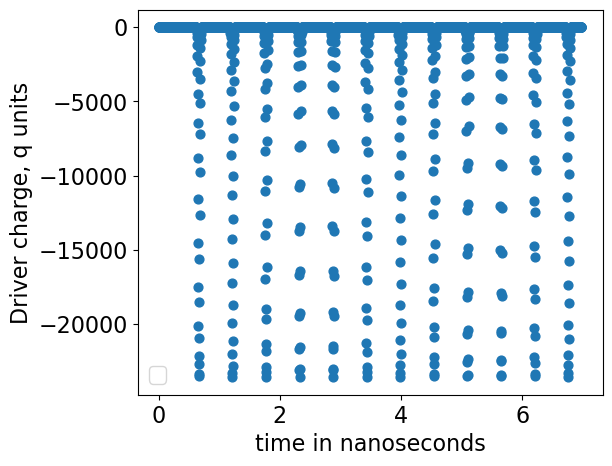

In [1243]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(tees,qs_drv,s=40)
ax.set_xlabel("time in nanoseconds")
ax.set_ylabel(r"Driver charge, q units")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xlim(1800,2500)
#plt.yscale('log')
plt.legend()
plt.show()

In [1244]:
delta_e_MeV

array([-1.12351835e-07, -5.67199080e+00,  4.41762922e-02, ...,
        2.01594760e+03,  2.01594760e+03,  2.01594760e+03])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


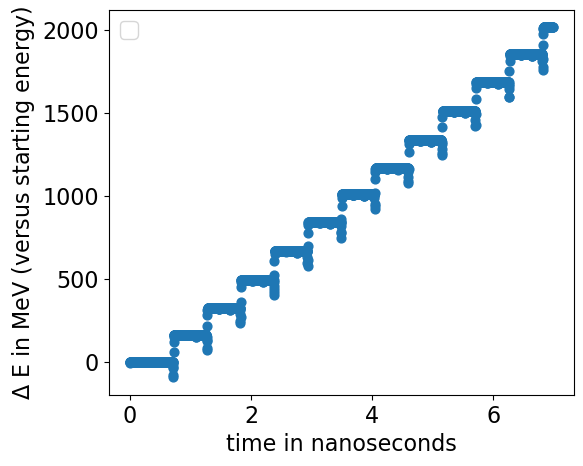

In [1245]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(tees,delta_e_MeV,s=40)
#ax.scatter(tees,np.abs(np.multiply(qs_drv,1E-2)),s=40)
ax.set_xlabel("time in nanoseconds")
ax.set_ylabel(r"$\Delta$ E in MeV (versus starting energy)")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xlim(0.,1)
#plt.yscale('log')
plt.legend()
plt.show()

/opt/conda/envs/jupyter/lib/python3.8/site-packages/matplotlib/lines.py:1206: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
/tmp/ipykernel_3901/1691351308.py:41: UserWarning: Legend does not support handles for Legend instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  fig.legend([legend1, legend2], ['Legend 1', 'Legend 2'], loc="lower right")
/opt/conda/envs/jupyter/lib/python3.8/site-packages/matplotlib/axis.py:125: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labelcolor == 'inherit':


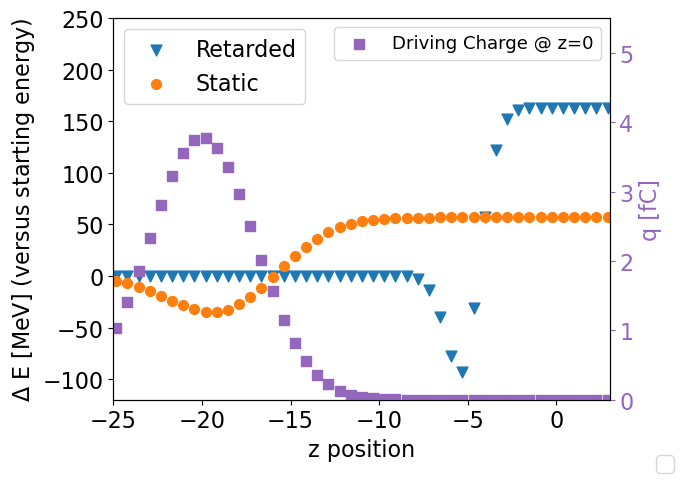

In [1246]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5), dpi=100)

# First scatter series
scatter1 = ax.scatter(zs, delta_e_MeV, s=60, marker='v', label="Retarded")
color1 = scatter1.get_facecolor()[0]

# Second scatter series
scatter2 = ax.scatter(zs, delta_e_MeV_save, s=50, label="Static", color='C1', marker='o')
color2 = scatter2.get_facecolor()[0]

# Create the twin Axes for the third scatter series
ax2 = ax.twinx()
bens_to_fC = 1.602E-4  # converts the amu mm ns charge units to femtocoloumbs
scatter3 = ax2.scatter(zs, np.abs(np.multiply(qs_drv, bens_to_fC)), s=50, label="Driving Charge @ z=0", color='C4', marker='s')
color3 = scatter3.get_facecolor()[0]

# Set labels and limits for the original Axes
ax.set_xlabel("z position")
ax.set_ylabel(r"$\Delta$ E [MeV] (versus starting energy)", color='k')
ax.set_xlim(-25, 3)
ax.set_ylim(-120, 250)
#ax.set_yscale('log')
ax.tick_params(axis='y', colors='k')

# Set labels and limits for the twin Axes
ax2.set_ylabel("q [fC]", color=color3)
ax2.set_ylim(0, 5.5)  # Adjust the limits as needed
ax2.tick_params(axis='y', colors=color3)

# Create the first legend on the left side
handles1, labels1 = ax.get_legend_handles_labels()
legend1 = ax.legend(handles1, labels1, loc="upper left")

# Create the second legend on the right side
handles2, labels2 = ax2.get_legend_handles_labels()
legend2 = ax2.legend(handles2, labels2, loc="upper right",fontsize=13)

# Add the second legend to the figure
fig.legend([legend1, legend2], ['Legend 1', 'Legend 2'], loc="lower right")

plt.tight_layout()
plt.show()


91196.01487378213


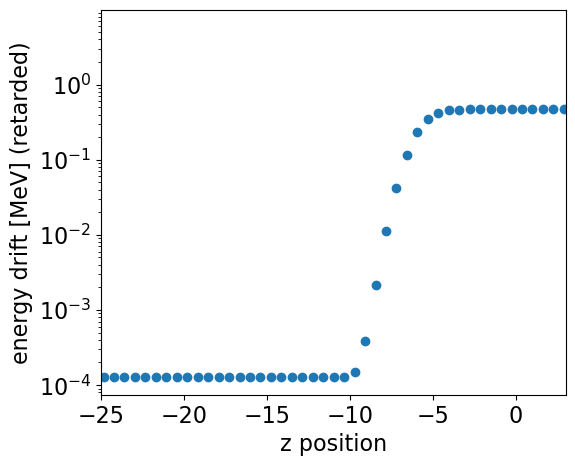

In [1247]:
e_p_consv_violation = np.subtract(np.add(np.add(np.square(Pxs),np.square(Pys)),np.square(Pzs)),np.square(Pts))
print(m_rider**2*c**2)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(zs,np.add(e_p_consv_violation,m_rider**2*c**2)*3.1)
ax.set_xlabel("z position")
ax.set_ylabel("energy drift [MeV] (retarded)")
ax.set_xlim(-25, 3)
ax.set_yscale('log')
plt.show()

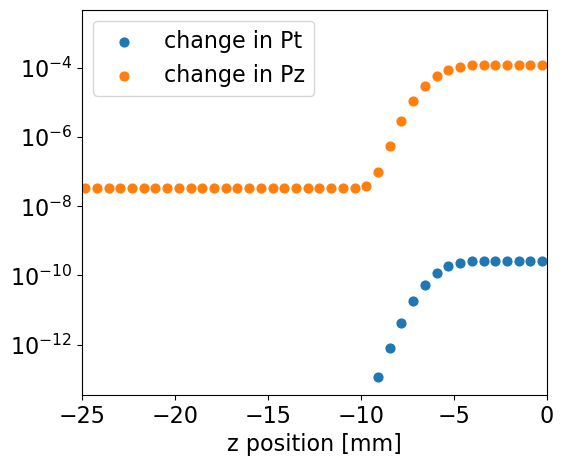

In [1248]:

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(zs,np.abs(Pts-init_rider['Pt']),s=40,label='change in Pt')
ax.scatter(zs,Pzs-init_rider['Pz'],s=40,label='change in Pz')
#ax.scatter(zs,delta_e_MeV_save,s=40,label="Static")
ax.set_xlabel("z position [mm]")
#ax.set_ylabel(r"total E in GeV ")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xticks(ticks=[-450],labels=["start"])3
plt.xlim(-25,0)
#plt.ylim(0.22,0.25)
#plt.axvline(x = -450, color = 'b', label = 'conducting surface disappears')
plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig("/home/benfolsom/notebooks/cov_ret_prab_figures/6.3_proton.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


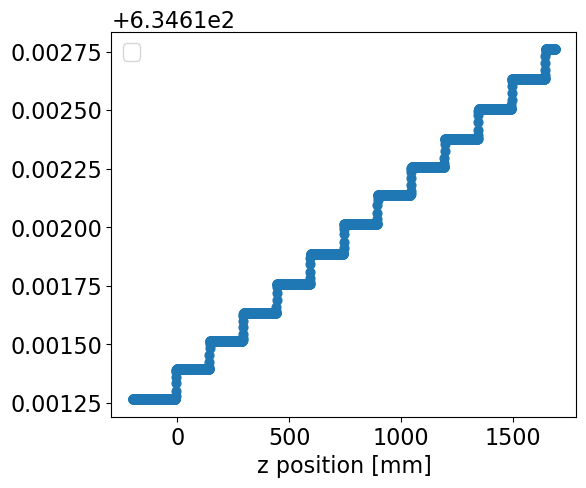

In [1104]:

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(zs,Pzs,s=40)
#ax.scatter(zs,delta_e_MeV_save,s=40,label="Static")
ax.set_xlabel("z position [mm]")
#ax.set_ylabel(r"total E in GeV ")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xticks(ticks=[-450],labels=["start"])3
#plt.xlim(-25,0)
#plt.ylim(0.22,0.25)
#plt.axvline(x = -450, color = 'b', label = 'conducting surface disappears')
#plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig("/home/benfolsom/notebooks/cov_ret_prab_figures/6.3_proton.pdf")

In [1193]:
# fig = plt.figure(figsize=(6,5))
# ax = fig.add_subplot(1, 1, 1) 
# ax.scatter(zs,tot_e_GeV,s=40)
# #ax.scatter(zs,delta_e_MeV_save,s=40,label="Static")
# ax.set_xlabel("z position [mm]")
# #ax.set_ylabel(r"total E in GeV ")
# #ax.axvline(30,color='g',label="wall paosition")
# #plt.xticks(ticks=[-450],labels=["start"])3
# plt.xlim(-25,5)
# #plt.ylim(0.22,0.25)
# #plt.axvline(x = -450, color = 'b', label = 'conducting surface disappears')
# #plt.yscale('log')
# plt.legend()
# plt.show()
# #plt.savefig("/home/benfolsom/notebooks/cov_ret_prab_figures/6.3_proton.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


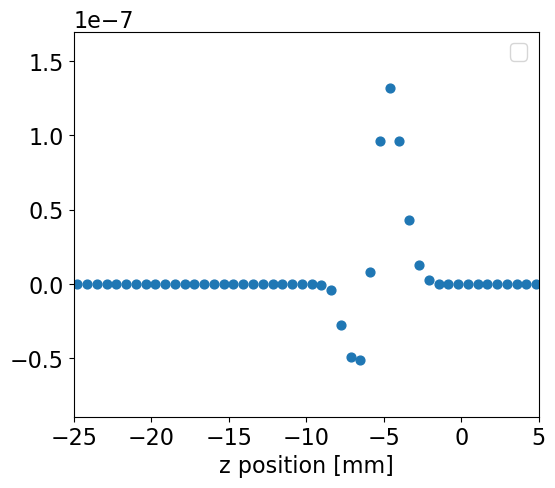

In [1194]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(zs,bdotzs,s=40)
#ax.scatter(zs,bzs_drv,s=40)
#ax.scatter(zs,delta_e_MeV_save,s=40,label="Static")
ax.set_xlabel("z position [mm]")
#ax.set_ylabel(r"total E in GeV ")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xticks(ticks=[-450],labels=["start"])3
plt.xlim(-25,5)
#plt.ylim(0.22,0.25)
#plt.axvline(x = -450, color = 'b', label = 'conducting surface disappears')
#plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig("/home/benfolsom/notebooks/cov_ret_prab_figures/6.3_proton.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


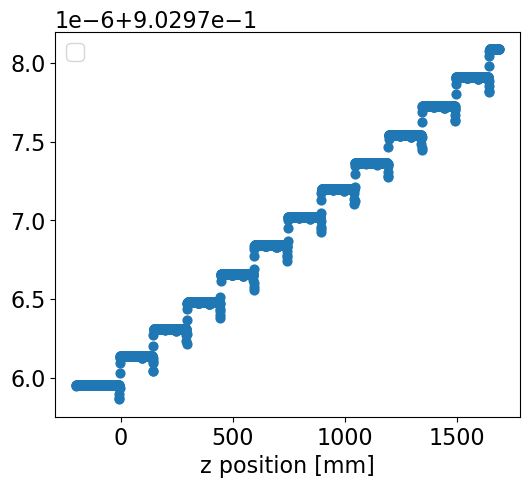

In [1197]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(zs,bzs,s=40)
#ax.scatter(zs,bzs_drv,s=40)
#ax.scatter(zs,delta_e_MeV_save,s=40,label="Static")
ax.set_xlabel("z position [mm]")
#ax.set_ylabel(r"total E in GeV ")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xticks(ticks=[-450],labels=["start"])3
#plt.xlim(-25,5)
#plt.ylim(0.22,0.25)
#plt.axvline(x = -450, color = 'b', label = 'conducting surface disappears')
#plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig("/home/benfolsom/notebooks/cov_ret_prab_figures/6.3_proton.pdf")

In [1108]:
#bzs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


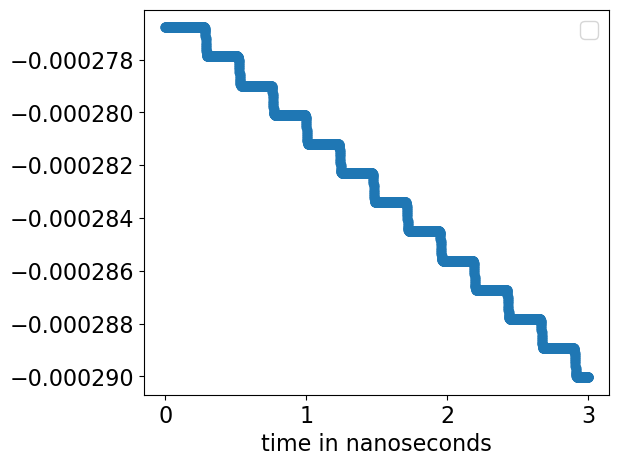

In [1198]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(tees_drv,Pzs_drv,s=40)
ax.set_xlabel("time in nanoseconds")
#ax.set_ylabel(r"$\Delta$ E in MeV (versus starting energy)")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xlim(1800,2500)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


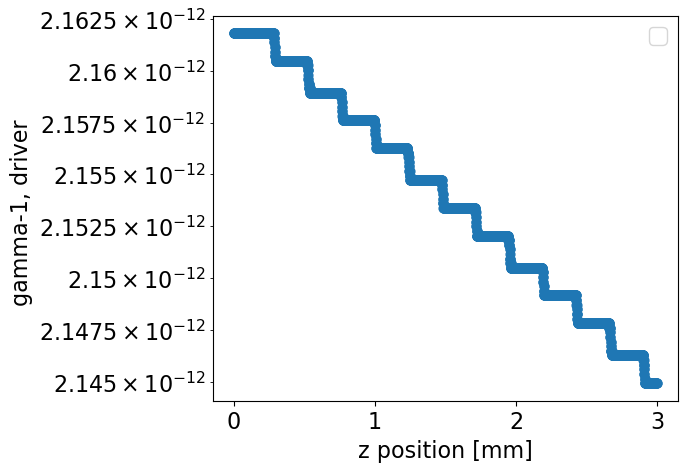

In [1199]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(tees_drv,np.subtract(gammas_drv,1),s=40)
#ax.scatter(zs,delta_e_MeV_save,s=40,label="Static")
ax.set_xlabel("z position [mm]")
ax.set_ylabel(r"gamma-1, driver ")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xticks(ticks=[-450],labels=["start"])3
#plt.xlim(-450.5,-448.5)
#plt.ylim(0.22,0.25)
#plt.axvline(x = -450, color = 'b', label = 'conducting surface disappears')
plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig("/home/benfolsom/notebooks/cov_ret_prab_figures/6.2_55GeV_elec_2GeV_meter.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


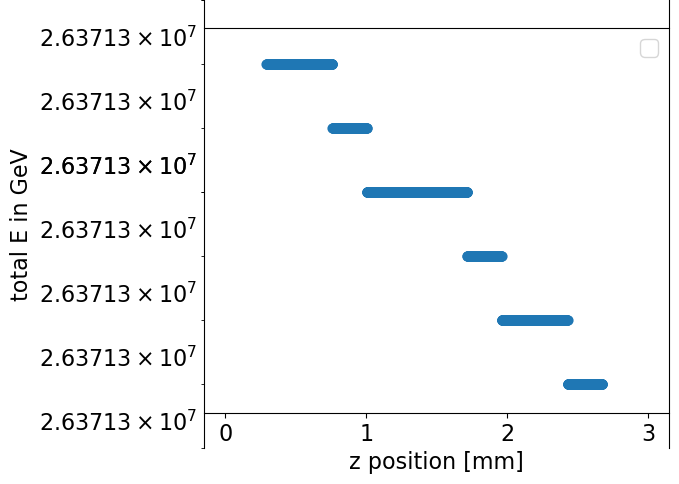

In [1200]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(tees_drv,tot_e_GeV_drv,s=40)
#ax.scatter(zs,delta_e_MeV_save,s=40,label="Static")
ax.set_xlabel("z position [mm]")
ax.set_ylabel(r"total E in GeV ")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xticks(ticks=[-450],labels=["start"])3
#plt.xlim(-450.5,-448.5)
#plt.ylim(0.22,0.25)
#plt.axvline(x = -450, color = 'b', label = 'conducting surface disappears')
plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig("/home/benfolsom/notebooks/cov_ret_prab_figures/6.2_55GeV_elec_2GeV_meter.pdf")

In [1201]:
btots = np.sqrt(np.square(bxs)+np.square(bys)+np.square(bzs))
gammas_new = np.sqrt(np.divide(1,1-np.square(btots)))
gammas_new*m_rider

array([2.34428752, 2.34428759, 2.34428759, ..., 2.34431203, 2.34431203,
       2.34431203])

In [1202]:
E_init_new = gammas_new[0]*m_rider*c**2*0.93149
E_init = gammas[0]*m_rider*c**2*0.93149

In [1203]:
1/np.sqrt(1-init_rider['bz'][0]**2)

2.3272533321804834

In [1204]:
gammas_new

array([2.32725326, 2.32725333, 2.32725333, ..., 2.32727759, 2.32727759,
       2.32727759])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


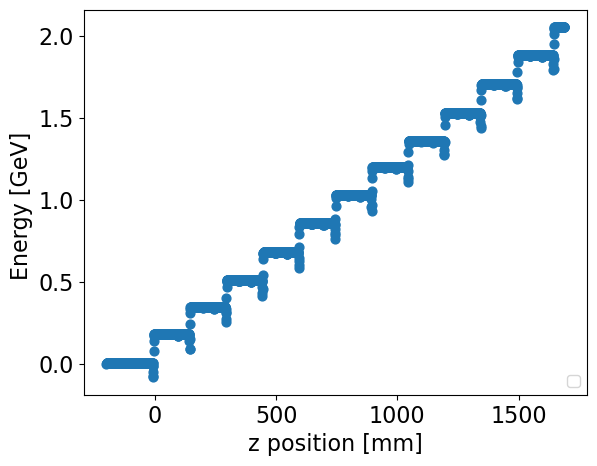

<Figure size 640x480 with 0 Axes>

In [1205]:
fig = plt.figure(figsize=(6.5,5),dpi=100)
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(zs,np.subtract(gammas_new*m_rider*c**2*0.93149,E_init_new),s=40)
#ax.scatter(zs,np.subtract(np.multiply(gammas,m_rider*c**2*0.93149),E_init),s=40)
#ax.scatter(zs,bzs_drv,s=40)
#ax.scatter(zs,delta_e_MeV_save,s=40,label="Static")
ax.set_xlabel("z position [mm]")
ax.set_ylabel(r"Energy [GeV] ")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xticks(ticks=[-450],labels=["start"])3
#plt.xlim(-25,6)
#plt.ylim(-0.22,0.25)
#plt.axvline(x = z_cutoff, color = 'b', label = 'conducting surface disappears')
#plt.yscale('log')
plt.legend(loc='lower right',fontsize=11)
plt.show()
plt.tight_layout()
#plt.savefig("/home/benfolsom/notebooks/cov_ret_prab_figures/6.3_proton.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


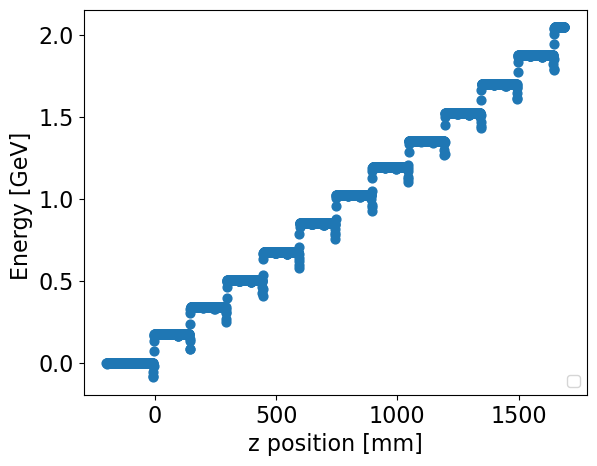

<Figure size 640x480 with 0 Axes>

In [1206]:
fig = plt.figure(figsize=(6.5,5),dpi=100)
ax = fig.add_subplot(1, 1, 1) 
#ax.scatter(zs,np.subtract(gammas_new*m_rider*c**2*0.93149,E_init),s=40)
ax.scatter(zs,np.subtract(np.multiply(gammas,m_rider*c**2*0.93149),E_init),s=40)
#ax.scatter(zs,bzs_drv,s=40)
#ax.scatter(zs,delta_e_MeV_save,s=40,label="Static")
ax.set_xlabel("z position [mm]")
ax.set_ylabel(r"Energy [GeV] ")
#ax.axvline(30,color='g',label="wall paosition")
#plt.xticks(ticks=[-450],labels=["start"])3
#plt.xlim(-25,5)
#plt.ylim(0.22,0.25)
#plt.axvline(x = z_cutoff, color = 'b', label = 'conducting surface disappears')
#plt.yscale('log')
plt.legend(loc='lower right',fontsize=11)
plt.show()
plt.tight_layout()
#plt.savefig("/home/benfolsom/notebooks/cov_ret_prab_figures/6.3_proton.pdf")

In [1207]:
gammas

[2.32725333226787,
 2.327253264985873,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921883,
 2.3272533327921

In [1208]:
init_rider['gamma']

array([2.32725333])

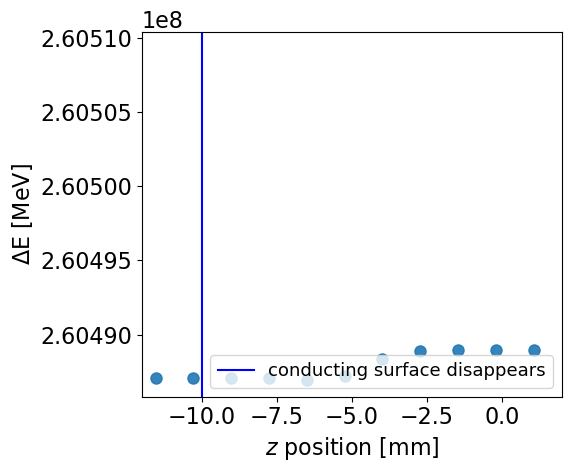

In [1049]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
#ax.scatter(zs,delta_e_keV,s=40)
ax.plot(zs,delta_e_MeV,'o',markersize=8,markevery=2,alpha=0.9)
ax.set_xlabel("$z$ position [mm]")
ax.set_ylabel(r"$\Delta$E [MeV]")
#ax.axvline(30,color='g',label="wall position")
#plt.xticks(ticks=[-450],labels=["start"])3
plt.xlim(z_cutoff-2,z_cutoff+12)
#plt.ylim(5e-4,10E-4)
plt.axvline(x = z_cutoff, color = 'b', label = 'conducting surface disappears')
plt.legend(fontsize=13,loc='lower right')
#plt.show()
plt.tight_layout()

#plt.savefig("/home/benfolsom/notebooks/electron_350MeV_switching_1_part_v12.png",dpi=600)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


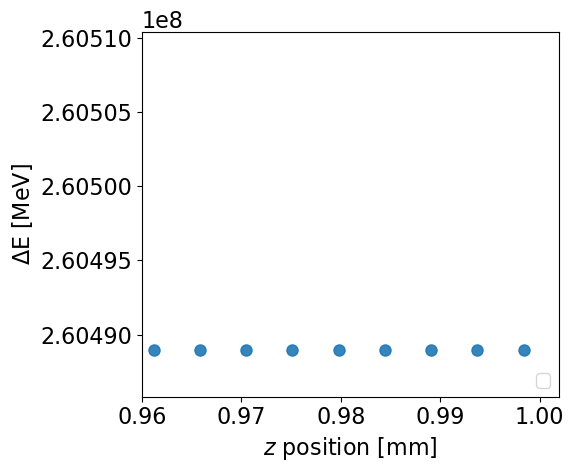

In [1050]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
#ax.scatter(zs,delta_e_keV,s=40)
ax.plot(tees,delta_e_MeV,'o',markersize=8,markevery=2,alpha=0.9)
ax.set_xlabel("$z$ position [mm]")
ax.set_ylabel(r"$\Delta$E [MeV]")
#ax.axvline(30,color='g',label="wall position")
#plt.xticks(ticks=[-450],labels=["start"])3
plt.xlim(0.96,1.002)
#plt.ylim(5e-4,10E-4)
#plt.axvline(x = z_cutoff, color = 'b', label = 'conducting surface disappears')
plt.legend(fontsize=13,loc='lower right')
#plt.show()
plt.tight_layout()

#plt.savefig("/home/benfolsom/notebooks/electron_350MeV_switching_1_part_v12.png",dpi=600)

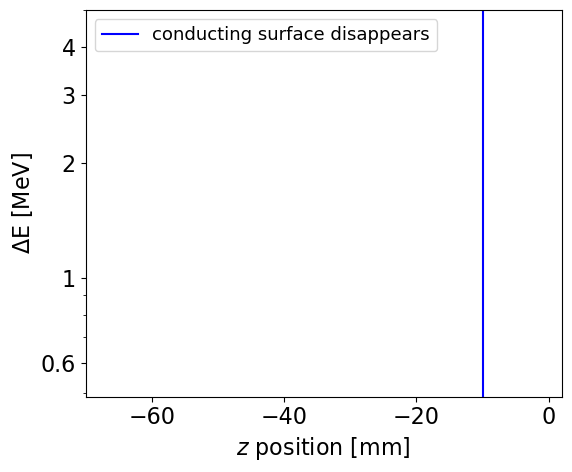

In [1051]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
#ax.scatter(zs,delta_e_keV,s=40)
ax.plot(zs,delta_e_MeV,'o',markersize=8,markevery=2,alpha=0.9)
ax.set_xlabel("$z$ position [mm]")
ax.set_ylabel(r"$\Delta$E [MeV]")
#ax.axvline(30,color='g',label="wall position")
#plt.xticks(ticks=[-450],labels=["start"])3
plt.xlim(z_cutoff-60,z_cutoff+12)
plt.ylim(4.9e-1,5)



#plt.xscale('log')
plt.yscale('log')
ax.set_yticks([0.6, 1, 2, 3, 4])
ax.set_yticklabels(['0.6', '1', '2', '3', '4'])
plt.axvline(x = z_cutoff, color = 'b', label = 'conducting surface disappears')
plt.legend(fontsize=13,loc='upper left')
#plt.show()
plt.tight_layout()

#plt.savefig("/home/benfolsom/notebooks/electron_350MeV_switching_1_part_v13.png",dpi=600)

In [1052]:
3.9-1.2

2.7

In [1053]:
0.965- 0.9875

-0.022500000000000075

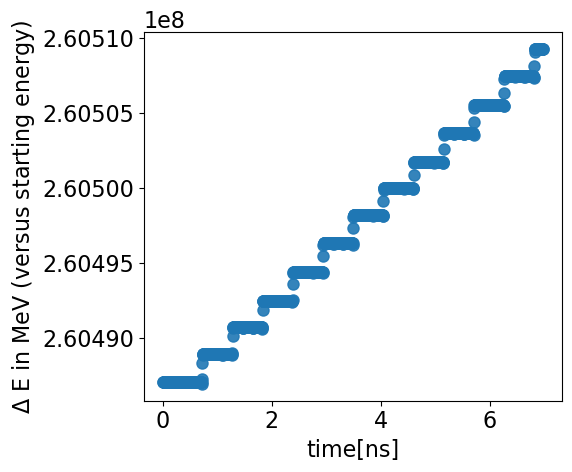

In [1054]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
#ax.scatter(zs,delta_e_keV,s=40)
ax.plot(np.divide(tees,gamma),delta_e_MeV,'o',markersize=8,markevery=2,alpha=0.9)
ax.set_xlabel("time[ns]")
ax.set_ylabel(r"$\Delta$ E in MeV (versus starting energy)")
#ax.axvline(30,color='g',label="wall position")
#plt.xticks(ticks=[-450],labels=["start"])3
#plt.xlim(0.0787,0.0803)
#plt.ylim(15.5,27.9)
#plt.ylim(15.5,27.9)
#plt.axvline(x = 53.7, color = 'b', label = 'conducting surface disappears')
#plt.axvline(x = 53.76, color = 'b', label = 'conducting surface disappears')

#plt.legend(fontsize=13,loc='lower left')
#plt.show()
plt.tight_layout()

#plt.savefig("/home/benfolsom/notebooks/electron_350MeV_switching_1_part_v11.png",dpi=600)

In [1055]:
0.080125-0.08

0.0001250000000000001

In [1056]:
(300/2)/c

0.5003461427972281

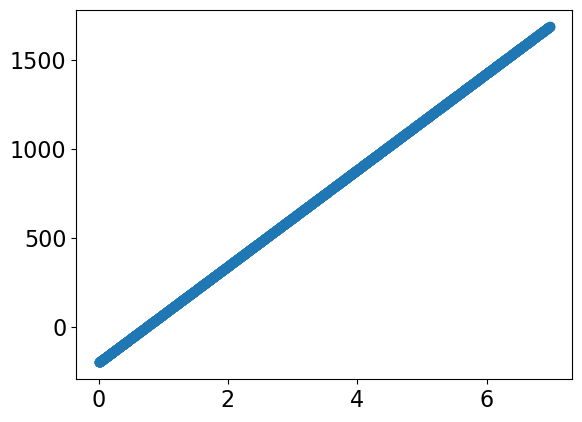

In [1057]:
plt.scatter(tees,zs)

In [1058]:
# Fit a linear polynomial to the data
coeffs = np.polyfit(tees,zs, 1)

# Extract the slope from the coefficients
slope = coeffs[0]

# Print the slope
print("Slope of the plot: {:.2f}".format(slope))


Slope of the plot: 270.71


In [1059]:
arr = np.array([1, 3, 5, 7, 9])

# Given value
value = 4

# Find the index of the element in the array that is closest to the given value
index = np.argmin(np.abs(np.subtract(zs,z_cutoff)))

# Retrieve the closest element in the array
closest_element = delta_e_MeV[index]
np.max(delta_e_MeV)-closest_element

22167.849419414997

In [1060]:
1.0432080589181787 / (c*6E-11)

57996125.37941045

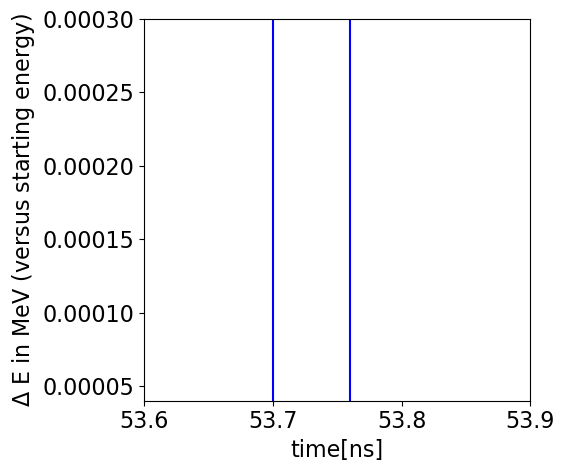

In [1061]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1, 1, 1) 
#ax.scatter(zs,delta_e_keV,s=40)
ax.plot(tees,bdotzs,'o',markersize=8,markevery=2,alpha=0.9)
ax.set_xlabel("time[ns]")
ax.set_ylabel(r"$\Delta$ E in MeV (versus starting energy)")
#ax.axvline(30,color='g',label="wall position")
#plt.xticks(ticks=[-450],labels=["start"])3
plt.xlim(53.6,53.9)
plt.ylim(4E-5,3E-4)
#plt.ylim(15.5,27.9)
plt.axvline(x = 53.7, color = 'b', label = 'conducting surface disappears')
plt.axvline(x = 53.76, color = 'b', label = 'conducting surface disappears')

#plt.legend(fontsize=13,loc='lower left')
#plt.show()
plt.tight_layout()

#plt.savefig("/home/benfolsom/notebooks/electron_350MeV_switching_1_part_v11.png",dpi=600)

In [1062]:
(bzs[6401]-bzs[6400])/step_size

IndexError: list index out of range

In [ ]:
tees[6400]

In [ ]:
step_size*4

In [ ]:
q**2*(1E-4)**2/(c*4*4*np.pi) # mm^3 amu ns^-2

In [ ]:
vdot = 0.0001*c

In [ ]:
gamma

In [ ]:
gamma_test=8870

In [ ]:
P_tot = 2/3* q**2/c**3 * vdot**2 * gamma**6

In [ ]:
P_tot #[mm^(3)*amu^(1)*ns^(-2)]; * m

In [ ]:
bzs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the electron energy range in MeV
electron_energy = np.logspace(6, 11, num=100, base=10)

# Calculate the corresponding relativistic gamma factors
gamma = electron_energy / 0.938

# Calculate the function tan(1/gamma)
y = np.tan(1/gamma)

# Plot the results
plt.plot(electron_energy, y)
plt.xscale('log')
plt.xlabel('Electron Energy (MeV)')
plt.ylabel('tan(1/gamma)')
plt.title('Electron Energy vs. tan(1/gamma)')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the electron energy range in MeV
electron_energy = np.logspace(0, 8, num=100, base=10)

# Calculate the corresponding relativistic gamma factors
gamma = electron_energy / 0.511

# Calculate the function tan(1/gamma)
y = np.tan(1/gamma)

# Plot the results
plt.plot(electron_energy, y)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Electron Energy (MeV)')
plt.ylabel(r'$\frac{p_{\bot}}{p_{\parallel}}$')



plt.show()



In [ ]:
gamma

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the electron energy range in MeV
electron_energy = np.logspace(0, 1, num=100, base=10)

#electron_energy = np.linspace(1, 3, num=100)

# Calculate the corresponding relativistic gamma factors for electrons
gamma_e = electron_energy / 0.000938

# Calculate the function tan(1/gamma) for electrons
y_e = np.tan(1/gamma_e)



# Create a figure with twin y-axes
fig, ax1 = plt.subplots()

# Plot the electron results on the left y-axis
ax1.plot(electron_energy, y_e, color='blue')
ax1.set_xscale('log')
ax1.set_xlabel('Energy (GeV)')
ax1.set_ylabel(r'$\frac{p_{\bot}}{p_{\parallel}}$')



# Display the plot
plt.show()


In [ ]:
gammas

In [ ]:
np.tan(1)

In [ ]:
np.pi/2

In [ ]:
anp.logspace(0, 3, num=100)